In [1]:
# default_exp plot

# Import

In [2]:
# export
import math

import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from camera_calib.utils import *

In [3]:
from IPython.core.debugger import set_trace

from camera_calib.calib import CamNode, CbNode  # for plotting

# Utility

In [4]:
# export
def plot_cb(M, cb_geom, c, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')
        
    # To make plot more intuitive, I've swapped the Y and Z axes
        
    ps_cb = cfpgrid(cb_geom.h_cb, cb_geom.w_cb, M.dtype, M.device)[[0,1,3,2]]
    ps_cb = torch.cat([ps_cb, ps_cb.new_zeros(len(ps_cb), 1)], dim=1)
    ps_cb_root = pmm(ps_cb, M, aug=True)
    ax.add_collection3d(Poly3DCollection([ps_cb_root[:,[0,2,1]]], 
                                         facecolors=c,
                                         edgecolors='k',
                                         alpha=0.5))
    return ax, ps_cb_root

In [5]:
# export
def plot_cam(M, sz_cam, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')
        
    # To make plot more intuitive, I've swapped the Y and Z axes

    ps_axes = M.new_tensor([[         0,          0,          0],
                            [2.0*sz_cam,          0,          0],
                            [         0,          0,          0],
                            [         0, 2.0*sz_cam,          0],
                            [         0,          0,          0],
                            [         0,          0, 2.0*sz_cam]])
    ps_text = M.new_tensor([[2.5*sz_cam,          0,          0],
                            [         0, 2.5*sz_cam,          0],
                            [         0,          0, 2.5*sz_cam]])
    pss_cam = [[[        0,        0,           0],
                [ sz_cam/2,  sz_cam/2, 1.5*sz_cam],
                [-sz_cam/2,  sz_cam/2, 1.5*sz_cam]],
               [[        0,         0,          0],
                [ sz_cam/2,  sz_cam/2, 1.5*sz_cam],
                [ sz_cam/2, -sz_cam/2, 1.5*sz_cam]],
               [[        0,         0,          0],
                [ sz_cam/2, -sz_cam/2, 1.5*sz_cam],
                [-sz_cam/2, -sz_cam/2, 1.5*sz_cam]],
               [[        0,         0,          0],
                [-sz_cam/2,  sz_cam/2, 1.5*sz_cam],
                [-sz_cam/2, -sz_cam/2, 1.5*sz_cam]],
               [[ sz_cam/2,  sz_cam/2,   sz_cam/2],
                [ sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [-sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [-sz_cam/2,  sz_cam/2,   sz_cam/2]],
               [[ sz_cam/2, -sz_cam/2,   sz_cam/2],
                [ sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,   sz_cam/2]],
               [[ sz_cam/2,  sz_cam/2,   sz_cam/2],
                [ sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [ sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [ sz_cam/2, -sz_cam/2,   sz_cam/2]],
               [[-sz_cam/2,  sz_cam/2,   sz_cam/2],
                [-sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,   sz_cam/2]],
               [[ sz_cam/2,  sz_cam/2,   sz_cam/2],
                [ sz_cam/2, -sz_cam/2,   sz_cam/2],
                [-sz_cam/2, -sz_cam/2,   sz_cam/2],
                [-sz_cam/2,  sz_cam/2,   sz_cam/2]],
               [[ sz_cam/2,  sz_cam/2,  -sz_cam/2],
                [ sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2, -sz_cam/2,  -sz_cam/2],
                [-sz_cam/2,  sz_cam/2,  -sz_cam/2]]] # TODO: Do one face and rotate it instead
    pss_cam = [M.new_tensor(ps_cam) for ps_cam in pss_cam]
    
    ps_axes_root = pmm(ps_axes, M, aug=True)
    ax.quiver(ps_axes_root[::2,0], ps_axes_root[::2,2], ps_axes_root[::2,1],
              ps_axes_root[1::2,0]-ps_axes_root[::2,0],
              ps_axes_root[1::2,2]-ps_axes_root[::2,2],
              ps_axes_root[1::2,1]-ps_axes_root[::2,1],
              color='r')

    ps_text_root = pmm(ps_text, M, aug=True)
    ax.text(*ps_text_root[0, [0,2,1]], 'x')
    ax.text(*ps_text_root[1, [0,2,1]], 'y')
    ax.text(*ps_text_root[2, [0,2,1]], 'z')

    pss_cam_root = [pmm(ps_cam, M, aug=True) for ps_cam in pss_cam]
    ax.add_collection3d(Poly3DCollection([ps_cam_root[:,[0,2,1]] for ps_cam_root in pss_cam_root], 
                                         facecolors='k', 
                                         alpha=0.5))

    return ax, torch.cat([ps_axes_root, ps_text_root] + pss_cam_root)

# Extrinsics plot

In [6]:
# export
def plot_extrinsics(Ms_cb, Ms_cam, cb_geom, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca(projection='3d')

    # To make plot more intuitive, I've swapped the Y and Z axes

    # Matplotlib currently has poor support for setting aspect ratio of 3D plots,
    # so keep track of all points, set bounding box, then set box aspect at the end
    ps_all = [] 

    # Plot calibration boards
    for M_cb, c in zip(Ms_cb, get_colors(len(Ms_cb))):
        _, ps_cb_root = plot_cb(M_cb, cb_geom, c, ax)
        ps_all.append(ps_cb_root)

    # Plot cameras
    sz_cam = min(cb_geom.h_cb, cb_geom.w_cb)/4 # heuristic; possibly make this an argument
    for M_cam in Ms_cam:
        _, ps_cam_root = plot_cam(M_cam, sz_cam, ax)
        ps_all.append(ps_cam_root)

    # Format plot
    ps_all = torch.cat(ps_all)
    bb = ps_bb(ps_all)
    ax.set_xlim(bb[0,0], bb[1,0])
    ax.set_ylim(bb[0,2], bb[1,2])
    ax.set_zlim(bb[0,1], bb[1,1])
    ax.set_box_aspect((bb[1]-bb[0])[[0,2,1]])
    ax.invert_zaxis()
    return ax

# Test

In [7]:
calib = torch.load('data/dot_vision_checker/calib.pth')

<Axes3DSubplot:>

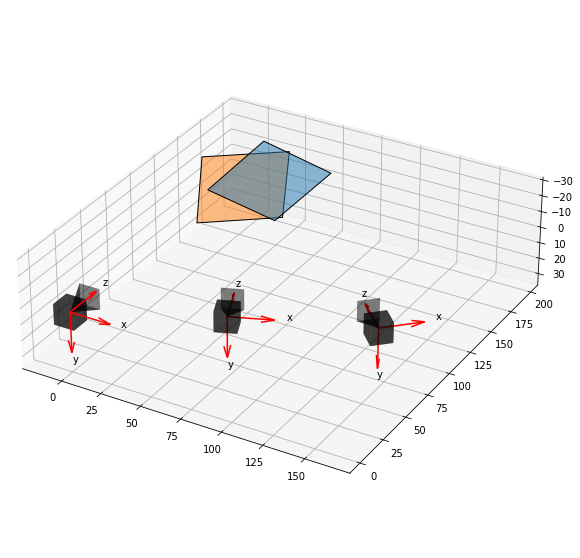

In [8]:
Ms_cb  = tuple(rigid_cb.get_param()  for rigid_cb  in calib['rigids_cb'])
Ms_cam = tuple(rigid_cam.get_param() for rigid_cam in calib['rigids_cam'])
plot_extrinsics(Ms_cb, Ms_cam, calib['cb_geom'])

# Build

In [9]:
build_notebook()

<IPython.core.display.Javascript object>

Converted plot.ipynb.
